In [1]:
! pip install grad-cam
! pip install medmnist

In [2]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import torch
import numpy as np
import cv2
import medmnist
from medmnist import INFO, Evaluator
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, random_split
from torchvision import models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
from torchvision.transforms import ToPILImage
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device("cpu")
if torch.backends.mps.is_available(): # MPS for Mac
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")

model = models.resnet50(pretrained=False)
num_input_channels = 1  # Grayscale images have only one channel
num_classes = 14
model.conv1 = nn.Conv2d(num_input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)

model.to(device)
target_layers = [model.layer4]

In [3]:
data_flag = 'chestmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
print(info)

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_subset_size = 2800
full_train_set = DataClass(split='train', transform=data_transform, download=True)
train_subset, _ = random_split(full_train_set, [train_subset_size, len(full_train_set) - train_subset_size])

val_subset_size = 600
val_set = DataClass(split='val', transform=data_transform, download=True)
val_subset, _ = random_split(val_set, [val_subset_size, len(val_set) - val_subset_size])

test_subset_size = 600
test_set = DataClass(split='test', transform=data_transform, download=True)
test_subset, _ = random_split(test_set, [test_subset_size, len(test_set) - test_subset_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

{'python_class': 'ChestMNIST', 'description': 'The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/chestmnist.npz?download=1', 'MD5': '02c8a6516a18b556561a56cbdd36c4a8', 'task': 'multi-label, binary-class', 'label': {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}, 'n_channels': 1, 'n_samples': {'train': 78468, 'val': 11219, 'test': 22433}, 'license': 'CC BY 4.0'}
Using downloaded and verified file: /home/viet/.medmnist/chestmnist.npz
Using downloaded

Classes of input image: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


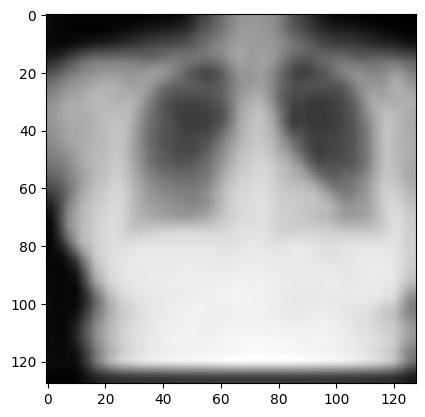

In [14]:
input_image = test_loader.dataset[0][0].unsqueeze(0).to(device)
print(f"Classes of input image: {test_loader.dataset[0][1]}")
input_image_class = test_loader.dataset[0][1]

resize_transform = transforms.Resize((128, 128), interpolation=Image.BICUBIC)
resized_input_image = resize_transform(input_image)

input_image_np = np.array(ToPILImage()(resized_input_image[0]))
input_image_np = np.float32(input_image_np) / 255

#plot the image
plt.imshow(input_image_np, cmap="gray")
plt.show()

# Showing the metrics on top of the CAM :
def custom_visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
        cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def custom_benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [# ("GradCAM", GradCAM(model=model, target_layers=target_layers)),
        ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
        # ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
        # ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
        # ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))
    ]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        input_image_rgb = np.stack((input_image_np,) * 3, axis=-1)
        visualization = show_cam_on_image(input_image_rgb, attribution, use_rgb=True)
        visualization = custom_visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
from IPython.display import display

# You are expected to save the models during training
# It is up to you to decide when and how to do so, but this is likely to influence the explanation results

### YOUR CODE BELOW ###
saved_models = None
num_classes = 14

def train(device, model, train_loader, epochs, learning_rate):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    model.train()
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for epoch in range(epochs):
        losses = []
        valid_losses = []
        accuracies = []

        for i, (data, target) in enumerate(tqdm(train_loader, desc='Training-loop')):
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            loss = criterion(output, target.float())
            preds = torch.sigmoid(output).detach().cpu() > 0.5  # Assuming threshold of 0.5
            labels = target.detach().cpu()

            # Calculate accuracy for each class separately
            class_acc = np.mean(preds.numpy() == labels.numpy(), axis=0)
            acc = np.mean(class_acc)
            
            losses.append(loss.item())
            accuracies.append(acc)

            for c in range(num_classes):
                class_correct[c] += torch.sum((preds[:, c] == labels[:, c]) & (labels[:, c] == 1)).item()
                class_total[c] += torch.sum(labels[:, c] == 1).item()

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for _, (data, target) in enumerate(tqdm(valid_loader, desc='Validation-loop')):
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device).long()
                output = model(data)
                loss = criterion(output, target.float())
                pred = output.detach().cpu() > 0.5  # Assuming threshold of 0.5
                valid_losses.append(loss.item())

        # We suggest you modify this code to run the continuous explanations
        print(f"Grad-cam testing")
        target_layers = [model.layer4]

        # load input image from bloodmnist dataloader
        input_image = train_loader.dataset[0][0].unsqueeze(0).to(device)
        resize_transform = transforms.Resize((128, 128))
        resized_input_image = resize_transform(input_image)
        
        class_accuracies = class_correct / class_total
        for c, acc in enumerate(class_accuracies):
            print(f"Class {c} Accuracy: {acc * 100:.2f}%")

        result_images = []
        for i in range(num_classes):
            result_image = custom_benchmark(resized_input_image, target_layers, category=i)
            result_images.append(result_image)
        # Display the result images in separate rows
        fig, axs = plt.subplots(1, num_classes, figsize=(30, 30 * num_classes))

        for class_idx in range(num_classes):
            axs[class_idx].imshow(result_images[class_idx])
            axs[class_idx].axis('off')
            axs[class_idx].set_title(f'Class {class_idx}')

        plt.show()
        # display(result_image)


        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(losses):.6f} "
            f"Validation loss: {np.mean(valid_losses):.6f} "
            f"Acc: {np.mean(accuracies) * 100:.6f} "
        )

    return model

print(f"Using device: {device}")
model = train(device, model, train_loader, epochs=60, learning_rate=0.0001)

# save model
saved_models = model
torch.save(saved_models, 'saved_models.pt')

Using device: cuda


Training-loop:   0%|          | 0/44 [00:00<?, ?it/s]

Validation-loop: 100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


Grad-cam testing
Class 0 Accuracy: 5.73%
Class 1 Accuracy: 1.54%
Class 2 Accuracy: 8.45%
Class 3 Accuracy: 14.51%
Class 4 Accuracy: 3.38%
Class 5 Accuracy: 0.00%
Class 6 Accuracy: 21.43%
Class 7 Accuracy: 4.17%
Class 8 Accuracy: 5.50%
Class 9 Accuracy: 11.32%
Class 10 Accuracy: 8.33%
Class 11 Accuracy: 0.00%
Class 12 Accuracy: 12.99%
Class 13 Accuracy: 0.00%


KeyboardInterrupt: 